Подключаемся к БД.

In [123]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-03-02 04:57:15--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-03-02 04:57:16 (478 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [124]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRe

In [125]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

Получаем данные и смотрим на них.

In [126]:
import pandas as pd

query = "SELECT * from public.credit_scoring"
data = pd.read_sql_query(query, conn)

conn.close()

In [127]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Сохраняем данные датасета

In [128]:
data.to_csv("cred_scor_data.csv", index=False)

Описание таблицы

In [129]:
data.shape

(150000, 11)

In [130]:
data.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

Разведовательный анализ

In [131]:
len(data)

150000

Пропущенные значения

In [132]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

обработка пропусков (MonthlyIncome and NumberOfDependents)

In [133]:
data.MonthlyIncome.value_counts()

5000.0     2757
4000.0     2106
6000.0     1934
3000.0     1758
0.0        1634
           ... 
16084.0       1
10523.0       1
55250.0       1
9242.0        1
7647.0        1
Name: MonthlyIncome, Length: 13594, dtype: int64

ищем медиану и заполняем пропуски

In [134]:
median = data['MonthlyIncome'].median()
#print(median)

data['MonthlyIncome'].fillna(median, inplace=True)

In [135]:
data.NumberOfDependents.value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64

In [136]:
median = data['NumberOfDependents'].median()
#print(median)

data['NumberOfDependents'].fillna(median, inplace=True)

In [137]:
data.isna().sum()


SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Описание таблицы

In [138]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Нужно предсказать значение SeriousDlqin2yrs. Там может быть 0 или 1

In [139]:
data['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

Матрица корреляции

In [140]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115386,0.125587,-0.007602,-0.017151,-0.029669,0.117175,-0.007038,0.102261,0.046869
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005898,-0.001314,0.003961,0.006513,-0.011281,-0.001061,0.006235,-0.001048,0.001193
age,-0.115386,-0.005898,1.000000,-0.062995,0.024188,0.027581,0.147705,-0.061005,0.033150,-0.057159,-0.215693
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,-0.062995,1.000000,-0.006542,-0.008370,-0.055312,0.983603,-0.030565,0.987005,-0.004590
DebtRatio,-0.007602,0.003961,0.024188,-0.006542,1.000000,-0.018006,0.049565,-0.008320,0.120046,-0.007533,-0.044476
MonthlyIncome,-0.017151,0.006513,0.027581,-0.008370,-0.018006,1.000000,0.086949,-0.010500,0.116273,-0.009252,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147705,-0.055312,0.049565,0.086949,1.000000,-0.079984,0.433959,-0.071077,0.074026
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061005,0.983603,-0.008320,-0.010500,-0.079984,1.000000,-0.045205,0.992796,-0.011962
NumberRealEstateLoansOrLines,-0.007038,0.006235,0.033150,-0.030565,0.120046,0.116273,0.433959,-0.045205,1.000000,-0.039722,0.129399
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.057159,0.987005,-0.007533,-0.009252,-0.071077,0.992796,-0.039722,1.000000,-0.012678


In [ ]:
corr = data.corr() #строим матрицу корреляции
corr.style.background_gradient(cmap='coolwarm') #зависимость/корреляция

In [19]:
data = data.drop(['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'],axis=1)

In [20]:
corr = data.corr() #строим матрицу корреляции
corr.style.background_gradient(cmap='coolwarm') #зависимость/корреляция

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115386,-0.007602,-0.017151,-0.029669,0.117175,-0.007038,0.046869
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005898,0.003961,0.006513,-0.011281,-0.001061,0.006235,0.001193
age,-0.115386,-0.005898,1.000000,0.024188,0.027581,0.147705,-0.061005,0.033150,-0.215693
DebtRatio,-0.007602,0.003961,0.024188,1.000000,-0.018006,0.049565,-0.008320,0.120046,-0.044476
MonthlyIncome,-0.017151,0.006513,0.027581,-0.018006,1.000000,0.086949,-0.010500,0.116273,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147705,0.049565,0.086949,1.000000,-0.079984,0.433959,0.074026
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061005,-0.008320,-0.010500,-0.079984,1.000000,-0.045205,-0.011962
NumberRealEstateLoansOrLines,-0.007038,0.006235,0.033150,0.120046,0.116273,0.433959,-0.045205,1.000000,0.129399
NumberOfDependents,0.046869,0.001193,-0.215693,-0.044476,0.066314,0.074026,-0.011962,0.129399,1.000000


Визуализация данных

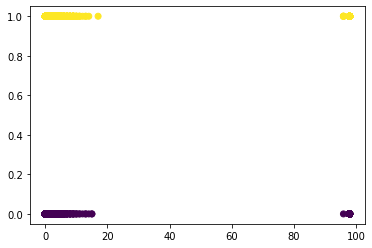

In [21]:
import matplotlib.pyplot as plt

plt.scatter(data['NumberOfTimes90DaysLate'], data['SeriousDlqin2yrs'], c=data['SeriousDlqin2yrs'])

In [22]:
data.groupby('SeriousDlqin2yrs')['NumberOfTimes90DaysLate'].mean()

SeriousDlqin2yrs
0    0.135225
1    2.091362
Name: NumberOfTimes90DaysLate, dtype: float64

Обучение модели

In [23]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']

Разобъём данные на train и test (test — 25% от всех данных)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
X.head

<bound method NDFrame.head of         RevolvingUtilizationOfUnsecuredLines  age    DebtRatio  MonthlyIncome  \
0                                   0.766127   45     0.802982         9120.0   
1                                   0.957151   40     0.121876         2600.0   
2                                   0.658180   38     0.085113         3042.0   
3                                   0.233810   30     0.036050         3300.0   
4                                   0.907239   49     0.024926        63588.0   
...                                      ...  ...          ...            ...   
149995                              0.040674   74     0.225131         2100.0   
149996                              0.299745   44     0.716562         5584.0   
149997                              0.246044   58  3870.000000         5400.0   
149998                              0.000000   30     0.000000         5716.0   
149999                              0.850283   64     0.249908         8158.0  

Маштабироование признакоов

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents
0,-0.021913,0.048196,-0.177746,0.112305,-0.089707,-0.063888,-0.016736,1.136978
1,-0.022635,-0.493560,-0.177736,1.595577,-0.284060,-0.063888,1.751985,1.136978
2,-0.022044,0.386793,-0.177805,0.183788,-0.284060,-0.063888,-0.901096,-0.665841
3,-0.018664,-2.051108,-0.177857,-0.393152,-1.450180,-0.063888,-0.901096,-0.665841
4,-0.022410,-1.306194,-0.177640,-0.173628,-0.478413,-0.063888,-0.016736,2.939798


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced') # объявление модели (добавил class_weight='balanced')
model.fit(Xtrain, ytrain) # обучение модели

pred_test = model.predict(Xtest) # предсказание классов



In [28]:
pred_test[:5]

array([0, 0, 1, 0, 0])

In [29]:
accuracy_score(ytest, pred_test)

0.6900266666666667

In [30]:
y.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [31]:
pred_test[:20]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

Валидация

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[24316, 10709],
       [  915,  1560]])

In [33]:
ytest.value_counts()

0    35025
1     2475
Name: SeriousDlqin2yrs, dtype: int64

In [34]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.6303030303030303

In [35]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.65743348, 0.34256652],
       [0.63714876, 0.36285124],
       [0.49136791, 0.50863209],
       [0.53324775, 0.46675225],
       [0.57775096, 0.42224904],
       [0.45240351, 0.54759649],
       [0.71947517, 0.28052483],
       [0.75783423, 0.24216577],
       [0.60919326, 0.39080674],
       [0.47015661, 0.52984339]])

Изменим порог вероятности

In [79]:
probs_Dql90 = probs[:,1]

classes = probs_Dql90 > 0.5

In [80]:
confusion_matrix(ytest, classes)

array([[24316, 10709],
       [  915,  1560]])

In [38]:
ytest.value_counts()

0    35025
1     2475
Name: SeriousDlqin2yrs, dtype: int64

In [39]:
recall_score(ytest, classes)

0.6303030303030303

Интерпретация модели

In [44]:
model.coef_, model.intercept_

(array([[-0.01285723, -0.46645085, -0.03858438, -0.35123362,  0.07546557,
          3.02269458,  0.08174756,  0.08912868]]), array([-0.14222866]))

In [45]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
1,age,-0.466451
3,MonthlyIncome,-0.351234
2,DebtRatio,-0.038584
0,RevolvingUtilizationOfUnsecuredLines,-0.012857
4,NumberOfOpenCreditLinesAndLoans,0.075466
6,NumberRealEstateLoansOrLines,0.081748
7,NumberOfDependents,0.089129
5,NumberOfTimes90DaysLate,3.022695


Метод ближайших соседей

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [76]:
knn.fit(Xtrain, ytrain)

pred_test2 = knn.predict_proba(Xtest)[:,1]

classes2 = pred_test2 > 0.2

confusion_matrix(ytest, classes2)

array([[33630,  1395],
       [ 1926,   549]])

Сохранение

In [96]:
#Xtest['predictions'] = probs_Dql90

#Xtest[['predictions']].to_csv("PredictionsDql90.csv", index=False)

In [52]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

In [53]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.127149726954112
recall:  0.6303030303030303
auc-roc:  0.7360566752463968


In [54]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.2 MB/s eta 0:00:00


In [55]:
from catboost import CatBoostClassifier, Pool

In [56]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [113]:
gbm = CatBoostClassifier(iterations=300,
                          depth=4,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

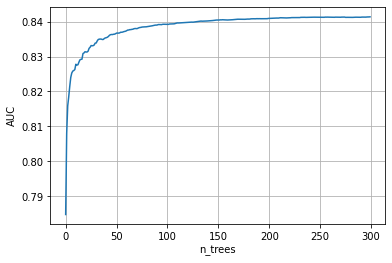

In [114]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [115]:
gbm_classes = (gbm_preds[:, 1] > 0.1)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.2406885294554088
recall:  0.6553535353535354
auc-roc:  0.8413439116359887


In [92]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
7,NumberOfDependents,1.724837
6,NumberRealEstateLoansOrLines,4.251700
3,MonthlyIncome,5.199051
4,NumberOfOpenCreditLinesAndLoans,8.234196
2,DebtRatio,9.038077
1,age,12.216557
5,NumberOfTimes90DaysLate,16.397520
0,RevolvingUtilizationOfUnsecuredLines,42.938061


In [116]:
confusion_matrix(ytest, gbm_classes)

array([[29908,  5117],
       [  853,  1622]])